In [1]:
import pandas as pd
from collections import defaultdict
import seaborn as sns
import matplotlib.pyplot as plt
import os
import zipfile

In [2]:
if not os.path.isfile("./data/schema-scores/schemapile/schemapile_scores.csv"):
    with zipfile.ZipFile("./data/schema-scores/schemapile/schemapile_scores.zip") as zip_ref:
        zip_ref.extractall("./data/schema-scores/schemapile/")

schemapile = pd.read_csv(
    "./data/schema-scores/schemapile/schemapile_scores.csv"
)

In [3]:
cat_label_dict = {
    'N1': 'Regular', 
    'N2': 'Low', 
    'N3': 'Least', 
    'N4': 'Regular-Improved',
    'NATIVE': 'Native Schema', 
    'combined': 'Combined'}
sns.set_theme(style="whitegrid")

In [4]:
schemapile.describe()

,TABLE_NAME,TABLE_SCORE,COLUMN_NAME,COLUMN_SCORE,MODEL,DATABASE_NAME
count,1330024,1330024,1330022,1330024,1330024,1330024
unique,78007,3,216225,3,1,22989
top,users,N1,id,N1,canine-s-collection2-upperlower-sequence-tags-...,174574_schema.sql
freq,19318,795275,69428,886052,1330024,4572


In [5]:
schemapile[["DATABASE_NAME", "TABLE_NAME", "TABLE_SCORE"]].drop_duplicates(
).query(
    "TABLE_SCORE == 'N3' and DATABASE_NAME == '000144_hive-schema-0.11.0.mssql.sql'"
).shape

(7, 3)

In [6]:
table_df = schemapile[[
    "DATABASE_NAME", "TABLE_SCORE", "TABLE_NAME", "MODEL"
    ]].drop_duplicates().pivot_table(
    index=["DATABASE_NAME", "TABLE_SCORE"],
    values=["MODEL"],
    aggfunc="count"
)
table_df = table_df.reset_index()
table_df = table_df.rename(columns={
    "MODEL": "TABLE_COUNT",
    "TABLE_SCORE": "NATURALNESS"
    })
table_df = table_df.set_index(
    ["DATABASE_NAME", "NATURALNESS"]
)
table_df.query("NATURALNESS == 'N3'")

,,TABLE_COUNT
DATABASE_NAME,NATURALNESS,
000032_create_table_ora.sql,N3,1
000050_dmt_oracle_1.0.sql,N3,1
000144_hive-schema-0.11.0.mssql.sql,N3,7
000151_008-HIVE-2246.postgres.sql,N3,2
000249_db_acl.sql,N3,3
...,...,...
694145_001_table_definitions.sql,N3,7
694737_banco_dados.sql,N3,8
694750_guppyci4.sql,N3,1


In [7]:
column_df = schemapile[["DATABASE_NAME", "COLUMN_SCORE", "MODEL"]].pivot_table(
    index=["DATABASE_NAME", "COLUMN_SCORE"],
    values=["MODEL"],
    aggfunc="count"
)
column_df = column_df.reset_index()
column_df = column_df.rename(columns={
    "MODEL": "COLUMN_COUNT",
    "COLUMN_SCORE": "NATURALNESS"
    })
column_df = column_df.set_index(["DATABASE_NAME", "NATURALNESS"])
column_df.head(3)

COLUMN_COUNT
DATABASE_NAME          NATURALNESS              
000011_tb_role_api.sql N1                      1
                       N2                      1
000014_psi.sql         N1                     14

In [8]:
nat_counts_df = table_df.join(
    column_df,
    how="outer"
).fillna(0)
nat_counts_df

TABLE_COUNT  COLUMN_COUNT
DATABASE_NAME               NATURALNESS                           
000011_tb_role_api.sql      N1                   0.0           1.0
                            N2                   1.0           1.0
000014_psi.sql              N1                   2.0          14.0
000032_create_table_ora.sql N1                   5.0          14.0
                            N3                   1.0           6.0
...                                              ...           ...
695929_ums.sql              N2                   1.0           1.0
                            N3                   0.0           1.0
695936_create_db.sql        N1                   3.0          19.0
                            N2                   4.0          17.0
                            N3                   0.0          15.0

[58629 rows x 2 columns]

In [9]:
nat_counts_df["IDENTIFIER_COUNT"] = nat_counts_df.apply(
    lambda row: row.TABLE_COUNT + row.COLUMN_COUNT,
    axis=1
)
nat_counts_df.head(3)


TABLE_COUNT  COLUMN_COUNT  \
DATABASE_NAME          NATURALNESS                              
000011_tb_role_api.sql N1                   0.0           1.0   
                       N2                   1.0           1.0   
000014_psi.sql         N1                   2.0          14.0   

                                    IDENTIFIER_COUNT  
DATABASE_NAME          NATURALNESS                    
000011_tb_role_api.sql N1                        1.0  
                       N2                        2.0  
000014_psi.sql         N1                       16.0

In [10]:
db_ident_totals = nat_counts_df.reset_index()[[
    "DATABASE_NAME", "NATURALNESS", "IDENTIFIER_COUNT"
    ]].groupby(["DATABASE_NAME"]).sum()[["IDENTIFIER_COUNT"]]
db_ident_totals.head(3)

,IDENTIFIER_COUNT
DATABASE_NAME,
000011_tb_role_api.sql,3.0
000014_psi.sql,16.0
000032_create_table_ora.sql,26.0


In [11]:
proportion = []
for row in nat_counts_df.reset_index().itertuples():
    proportion.append(row.IDENTIFIER_COUNT / db_ident_totals.at[row.DATABASE_NAME, "IDENTIFIER_COUNT"])
nat_counts_df["PROPORTION"] = proportion
nat_counts_df

TABLE_COUNT  COLUMN_COUNT  \
DATABASE_NAME               NATURALNESS                              
000011_tb_role_api.sql      N1                   0.0           1.0   
                            N2                   1.0           1.0   
000014_psi.sql              N1                   2.0          14.0   
000032_create_table_ora.sql N1                   5.0          14.0   
                            N3                   1.0           6.0   
...                                              ...           ...   
695929_ums.sql              N2                   1.0           1.0   
                            N3                   0.0           1.0   
695936_create_db.sql        N1                   3.0          19.0   
                            N2                   4.0          17.0   
                            N3                   0.0          15.0   

                                         IDENTIFIER_COUNT  PROPORTION  
DATABASE_NAME               NATURALNESS                                
000011_tb_role_api.sql      N1                        1.0    0.333333  
                            N2                        2.0    0.666667  
000014_psi.sql              N1                       16.0    1.000000  
000032_create_table_ora.sql N1                       19.0    0.730769  
                            N3                        7.0    0.269231  
...                                                   ...         ...  
695929_ums.sql              N2                        2.0    0.400000  
                            N3                        1.0    0.200000  
695936_create_db.sql        N1                       22.0    0.379310  
                            N2                       21.0    0.362069  
                            N3                       15.0    0.258621  

[58629 rows x 4 columns]

In [12]:
nat_counts_df.reset_index().head(3)

,DATABASE_NAME,NATURALNESS,TABLE_COUNT,COLUMN_COUNT,IDENTIFIER_COUNT,PROPORTION
0,000011_tb_role_api.sql,N1,0.0,1.0,1.0,0.333333
1,000011_tb_role_api.sql,N2,1.0,1.0,2.0,0.666667
2,000014_psi.sql,N1,2.0,14.0,16.0,1.000000


In [13]:
nat_counts_df.reset_index().query(
    "NATURALNESS == 'N3' and PROPORTION > 0.1"
)

,DATABASE_NAME,NATURALNESS,TABLE_COUNT,COLUMN_COUNT,IDENTIFIER_COUNT,PROPORTION
4,000032_create_table_ora.sql,N3,1.0,6.0,7.0,0.269231
7,000050_dmt_oracle_1.0.sql,N3,1.0,39.0,40.0,0.203046
10,000054_start_db.sql,N3,0.0,4.0,4.0,0.137931
18,000094_ampache.sql,N3,0.0,32.0,32.0,0.155340
27,000144_hive-schema-0.11.0.mssql.sql,N3,7.0,23.0,30.0,0.121457
...,...,...,...,...,...,...
58612,695757_1_exchange_bot_schema.sql,N3,0.0,3.0,3.0,0.111111
58618,695829_gamepoint.sql,N3,0.0,5.0,5.0,0.156250
58621,695831_migrations.sql,N3,0.0,10.0,10.0,0.126582
58625,695929_ums.sql,N3,0.0,1.0,1.0,0.200000


In [14]:
def zero():
    return 0
combined_nat = defaultdict(zero)
comb_weights={'N1': 1, 'N2': .5, 'N3': 0}
for row in nat_counts_df.reset_index().itertuples():
    combined_nat[row.DATABASE_NAME] += (comb_weights[row.NATURALNESS] * row.PROPORTION)
combined_nat_df = pd.DataFrame({
    "DATABASE_NAME": list(combined_nat.keys()),
    "COMBINED_NATURALNESS": [combined_nat[k] for k in combined_nat]
})

/tmp/ipykernel_13490/3041063388.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_xticklabels(g.get_xticklabels(), fontsize=12)
/tmp/ipykernel_13490/3041063388.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_yticklabels(g.get_yticklabels(), fontsize=12)


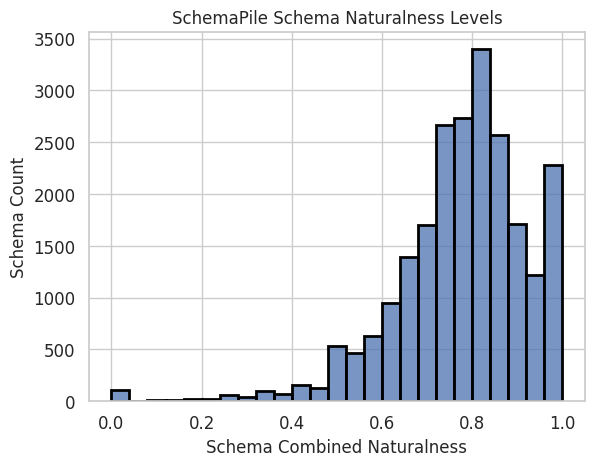

In [16]:
g = sns.histplot(
    data=combined_nat_df.rename(columns={
        "COMBINED_NATURALNESS": "Schema Combined Naturalness"
    }),
    x="Schema Combined Naturalness",
    stat="count",
    cumulative=False,
    fill=True,
    # element="step",
    bins=25,
    linewidth=2,
    edgecolor="black",
)
g.set_xticklabels(g.get_xticklabels(), fontsize=12)
g.set_yticklabels(g.get_yticklabels(), fontsize=12)
g.set_xlabel(g.get_xlabel(), fontsize=12)
g.set_ylabel(g.get_ylabel(), fontsize=12)
plt.ylabel("Schema Count")
g.set_title("SchemaPile Schema Naturalness Levels")
g.figure.savefig("./figure_output/schemapile_naturalness_histogram.pdf", dpi=300, bbox_inches="tight")


In [17]:
combined_nat_df.query("COMBINED_NATURALNESS <= 0.7").shape[0]# / combined_nat_df.shape[0]

5622

In [18]:
nat_counts_df.reset_index()[nat_counts_df.reset_index().DATABASE_NAME.isin(
    combined_nat_df.query("COMBINED_NATURALNESS <= 0.7").DATABASE_NAME
)]

,DATABASE_NAME,NATURALNESS,TABLE_COUNT,COLUMN_COUNT,IDENTIFIER_COUNT,PROPORTION
0,000011_tb_role_api.sql,N1,0.0,1.0,1.0,0.333333
1,000011_tb_role_api.sql,N2,1.0,1.0,2.0,0.666667
6,000050_dmt_oracle_1.0.sql,N2,25.0,132.0,157.0,0.796954
7,000050_dmt_oracle_1.0.sql,N3,1.0,39.0,40.0,0.203046
28,000148_up.sql,N1,0.0,1.0,1.0,0.071429
...,...,...,...,...,...,...
58624,695929_ums.sql,N2,1.0,1.0,2.0,0.400000
58625,695929_ums.sql,N3,0.0,1.0,1.0,0.200000
58626,695936_create_db.sql,N1,3.0,19.0,22.0,0.379310
58627,695936_create_db.sql,N2,4.0,17.0,21.0,0.362069


In [19]:
nat_threshold=0.7
hist_df = pd.concat([
    schemapile[schemapile.DATABASE_NAME.isin(
        combined_nat_df.query(f"COMBINED_NATURALNESS <= {nat_threshold}").DATABASE_NAME
    )][["DATABASE_NAME", "TABLE_NAME", "TABLE_SCORE"]].drop_duplicates(

    ).rename(
        columns={"TABLE_SCORE": "Tables"}
    ).melt(
        id_vars=["DATABASE_NAME"],
        value_vars=["Tables"],
        value_name="Identifier Naturalness",
        var_name="Identifier Type"
    ),
    schemapile[schemapile.DATABASE_NAME.isin(
        combined_nat_df.query(f"COMBINED_NATURALNESS <= {nat_threshold}").DATABASE_NAME
    )][["DATABASE_NAME", "COLUMN_NAME", "COLUMN_SCORE"]].rename(
        columns={"COLUMN_SCORE": "Columns"}
    ).melt(
        id_vars=["DATABASE_NAME"],
        value_vars=["Columns"],
        value_name="Identifier Naturalness",
        var_name="Identifier Type"
    )
])


/tmp/ipykernel_13490/1233046023.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_xticklabels(


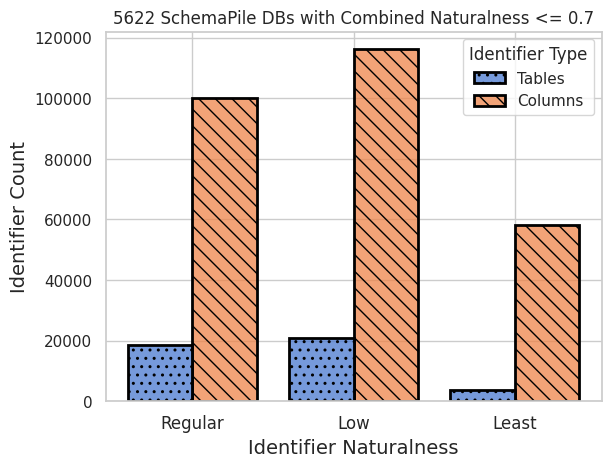

In [21]:
num_dbs = combined_nat_df.query(f"COMBINED_NATURALNESS <= {nat_threshold}").shape[0]
title = f"{num_dbs} SchemaPile DBs with Combined Naturalness <= {nat_threshold}"
g = sns.histplot(
    data=hist_df,
    x="Identifier Naturalness",
    hue="Identifier Type",
    multiple="dodge",
    palette="muted",
    linewidth=2,
    edgecolor="black",
    shrink=0.8
)
hatches = ["\\\\", ".."]

for i, thisbar in enumerate(g.patches):
    if i in [0, 1, 2]:
        thisbar.set_hatch(hatches[0])
    else:
        thisbar.set_hatch(hatches[1])

g.set_title(title)
g.set_xticklabels(
    [cat_label_dict[l.get_text()] for l in g.get_xticklabels()],
    fontsize=12
    )
g.legend_.get_patches()[0].set_hatch(hatches[1])
g.legend_.get_patches()[1].set_hatch(hatches[0])
g.set_ylabel("Identifier Count", fontsize=14)
g.set_xlabel(g.get_xlabel(), fontsize=14)
g.figure.savefig("./figure_output/schemapile_lownat_histogram.pdf", dpi=300)

## Whitespace analysis

In [22]:
schemapile.head(3)

,TABLE_NAME,TABLE_SCORE,COLUMN_NAME,COLUMN_SCORE,MODEL,DATABASE_NAME
0,courses,N1,course_id,N1,canine-s-collection2-upperlower-sequence-tags-...,692793_2021-09-21-08-02.backup.sql
1,courses,N1,teacher_id,N1,canine-s-collection2-upperlower-sequence-tags-...,692793_2021-09-21-08-02.backup.sql
2,courses,N1,created_on,N1,canine-s-collection2-upperlower-sequence-tags-...,692793_2021-09-21-08-02.backup.sql


In [23]:
table_whitespace_counter = 0
column_whitespace_counter = 0
for row in schemapile.itertuples():
    if " " in str(row.COLUMN_NAME):
        column_whitespace_counter += 1

for t in schemapile.TABLE_NAME.unique():
    if " " in t:
        table_whitespace_counter += 1

print("Columns", column_whitespace_counter)
print("Tables", table_whitespace_counter)

Columns 808
Tables 63


In [24]:
table_counter = 0 
for t in schemapile.TABLE_NAME.unique():
    if "table" in t.lower():
        table_counter += 1
print("Tables with the word table in it:", table_counter)

Tables with the word table in it: 728
